# Dự báo chuỗi thời gian với ARIMA

Trong notebook này, chúng ta sẽ thực hiện:
- chuẩn bị dữ liệu chuỗi thời gian để huấn luyện mô hình dự báo chuỗi thời gian ARIMA
- triển khai một mô hình ARIMA đơn giản để dự báo các bước tiếp theo trong HORIZON (từ thời điểm *t+1* đến *t+HORIZON*) trong chuỗi thời gian
- đánh giá mô hình

Dữ liệu trong ví dụ này được lấy từ cuộc thi dự báo GEFCom2014. Nó bao gồm 3 năm dữ liệu tải điện và nhiệt độ theo giờ từ năm 2012 đến 2014. Nhiệm vụ là dự báo các giá trị tải điện trong tương lai. Trong ví dụ này, chúng ta sẽ minh họa cách dự báo một bước thời gian tiếp theo, chỉ sử dụng dữ liệu tải điện lịch sử.

Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli và Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, tháng 7-tháng 9, 2016.


## Cài đặt các thư viện cần thiết
Bắt đầu bằng cách cài đặt một số thư viện cần thiết. Các thư viện này cùng với phiên bản tương ứng đã được kiểm chứng hoạt động tốt cho giải pháp:

* `statsmodels == 0.12.2`
* `matplotlib == 3.4.2`
* `scikit-learn == 0.24.2`


In [16]:
!pip install statsmodels

/bin/sh: pip: command not found


In [17]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [18]:
energy = load_data('./data')[['load']]
energy.head(10)

load
2012-01-01 00:00:00 2,698.00
2012-01-01 01:00:00 2,558.00
2012-01-01 02:00:00 2,444.00
2012-01-01 03:00:00 2,402.00
2012-01-01 04:00:00 2,403.00
2012-01-01 05:00:00 2,453.00
2012-01-01 06:00:00 2,560.00
2012-01-01 07:00:00 2,719.00
2012-01-01 08:00:00 2,916.00
2012-01-01 09:00:00 3,105.00

Vẽ tất cả dữ liệu tải có sẵn (tháng 1 năm 2012 đến tháng 12 năm 2014)


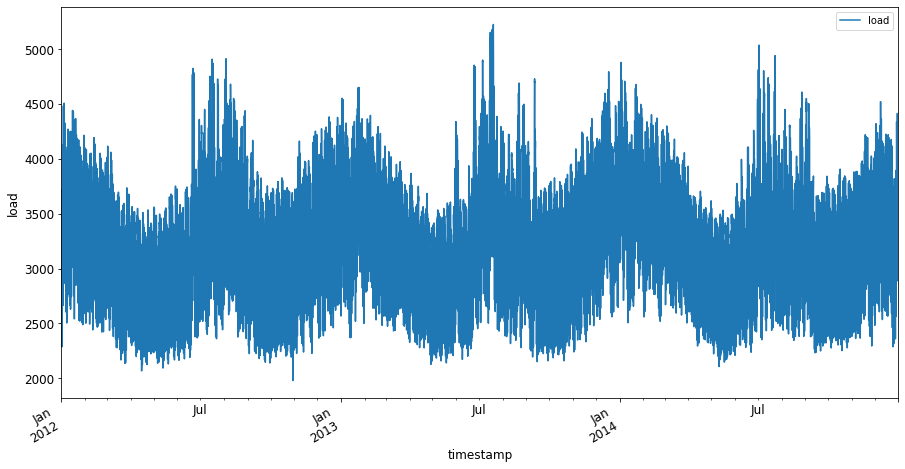

In [19]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Tạo tập dữ liệu huấn luyện và kiểm tra

### Giới thiệu

Khi xây dựng một mô hình học máy, việc chia dữ liệu thành các tập huấn luyện và kiểm tra là một bước quan trọng. Tập huấn luyện được sử dụng để dạy mô hình, trong khi tập kiểm tra được sử dụng để đánh giá hiệu suất của mô hình trên dữ liệu chưa từng thấy.

### Tại sao cần chia dữ liệu?

Việc chia dữ liệu giúp đảm bảo rằng mô hình không chỉ hoạt động tốt trên dữ liệu mà nó đã được huấn luyện, mà còn có khả năng tổng quát hóa để dự đoán chính xác trên dữ liệu mới. Điều này giúp tránh hiện tượng **overfitting** (quá khớp), khi mô hình học quá chi tiết từ dữ liệu huấn luyện và không thể áp dụng tốt cho dữ liệu khác.

### Cách chia dữ liệu

Dưới đây là các bước cơ bản để chia dữ liệu:

1. **Thu thập dữ liệu**: Đảm bảo rằng bạn có một tập dữ liệu đủ lớn và đại diện cho vấn đề bạn đang giải quyết.
2. **Xáo trộn dữ liệu**: Trộn ngẫu nhiên dữ liệu để đảm bảo rằng không có sự thiên vị nào trong cách dữ liệu được sắp xếp.
3. **Chia thành hai tập**:
   - **Tập huấn luyện**: Thường chiếm khoảng 70-80% tổng dữ liệu.
   - **Tập kiểm tra**: Thường chiếm khoảng 20-30% tổng dữ liệu.

### Ví dụ

Dưới đây là một ví dụ minh họa cách chia dữ liệu bằng Python:

```python
from sklearn.model_selection import train_test_split

# Giả sử X là dữ liệu đầu vào và y là nhãn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Kích thước tập huấn luyện:", len(X_train))
print("Kích thước tập kiểm tra:", len(X_test))
```

### Lưu ý

[!NOTE] Đảm bảo rằng bạn sử dụng cùng một giá trị `random_state` để kết quả có thể tái lập.

[!WARNING] Không sử dụng dữ liệu kiểm tra trong quá trình huấn luyện mô hình. Điều này có thể dẫn đến kết quả không chính xác khi đánh giá mô hình.

[!TIP] Nếu bạn có một tập dữ liệu rất lớn, bạn có thể cân nhắc sử dụng một phần nhỏ của dữ liệu để kiểm tra, thay vì 20-30%.

[!IMPORTANT] Đối với các bài toán cụ thể như phân loại hoặc dự đoán chuỗi thời gian, cách chia dữ liệu có thể cần được điều chỉnh để phù hợp với đặc điểm của dữ liệu.


In [20]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'    

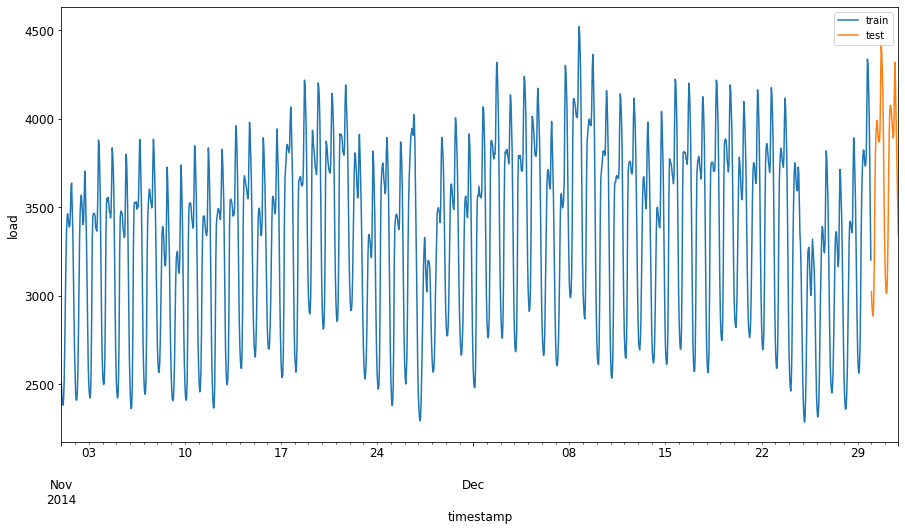

In [21]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [22]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [23]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

load
2014-11-01 00:00:00  0.10
2014-11-01 01:00:00  0.07
2014-11-01 02:00:00  0.05
2014-11-01 03:00:00  0.04
2014-11-01 04:00:00  0.06
2014-11-01 05:00:00  0.10
2014-11-01 06:00:00  0.19
2014-11-01 07:00:00  0.31
2014-11-01 08:00:00  0.40
2014-11-01 09:00:00  0.48

Dữ liệu gốc so với dữ liệu đã được chuẩn hóa:


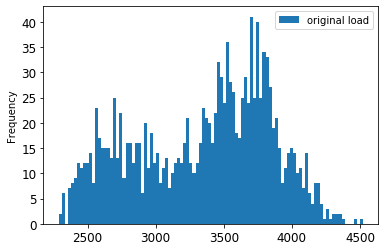

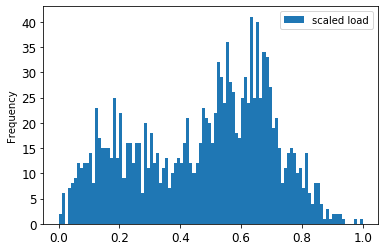

In [24]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

Hãy cùng chuẩn hóa dữ liệu kiểm tra


In [25]:
test['load'] = scaler.transform(test)
test.head()

load
2014-12-30 00:00:00  0.33
2014-12-30 01:00:00  0.29
2014-12-30 02:00:00  0.27
2014-12-30 03:00:00  0.27
2014-12-30 04:00:00  0.30

In [26]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [27]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.239
Date:                            Thu, 30 Sep 2021   AIC                          -6942.477
Time:                                    14:36:28   BIC                          -6911.050
Sample:                                11-01-2014   HQIC                         -6930.725
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8403      0.016     52.226      0.000       0.809       0.872
ar.L2         -0.5220      0.034   

Tạo một điểm dữ liệu kiểm tra cho mỗi bước HORIZON.


In [28]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

load  load+1  load+2
2014-12-30 00:00:00  0.33    0.29    0.27
2014-12-30 01:00:00  0.29    0.27    0.27
2014-12-30 02:00:00  0.27    0.27    0.30
2014-12-30 03:00:00  0.27    0.30    0.41
2014-12-30 04:00:00  0.30    0.41    0.57

In [29]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

So sánh dự đoán với tải thực tế


In [30]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h  prediction   actual
0 2014-12-30 00:00:00  t+1    3,008.74 3,023.00
1 2014-12-30 01:00:00  t+1    2,955.53 2,935.00
2 2014-12-30 02:00:00  t+1    2,900.17 2,899.00
3 2014-12-30 03:00:00  t+1    2,917.69 2,886.00
4 2014-12-30 04:00:00  t+1    2,946.99 2,963.00

Tính **lỗi phần trăm tuyệt đối trung bình (MAPE)** trên tất cả các dự đoán

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}|\frac{actual_t - predicted_t}{actual_t}|$$


In [31]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [32]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.5570581332313952 %


In [33]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  1.1460048657704118 %


Vẽ biểu đồ dự đoán so với thực tế cho tuần đầu tiên của tập kiểm tra


No handles with labels found to put in legend.


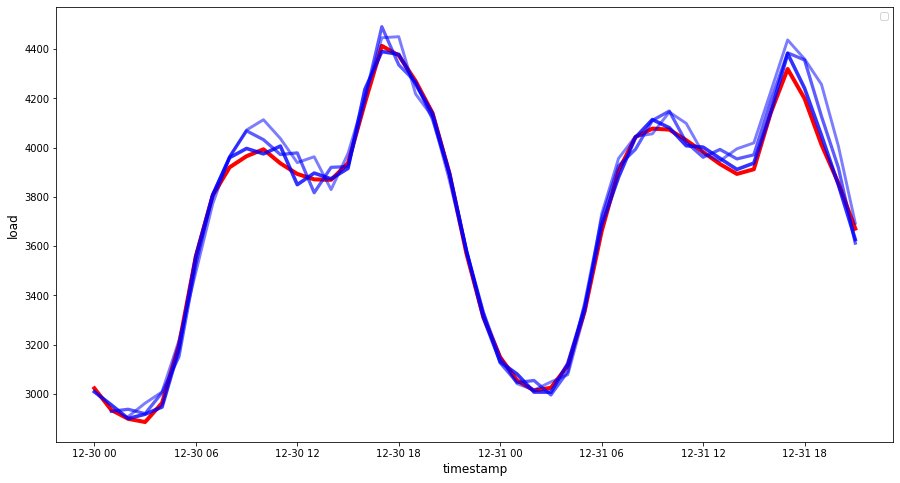

In [34]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()


---

**Tuyên bố miễn trừ trách nhiệm**:  
Tài liệu này đã được dịch bằng dịch vụ dịch thuật AI [Co-op Translator](https://github.com/Azure/co-op-translator). Mặc dù chúng tôi cố gắng đảm bảo độ chính xác, xin lưu ý rằng các bản dịch tự động có thể chứa lỗi hoặc không chính xác. Tài liệu gốc bằng ngôn ngữ bản địa nên được coi là nguồn tham khảo chính thức. Đối với các thông tin quan trọng, chúng tôi khuyến nghị sử dụng dịch vụ dịch thuật chuyên nghiệp từ con người. Chúng tôi không chịu trách nhiệm cho bất kỳ sự hiểu lầm hoặc diễn giải sai nào phát sinh từ việc sử dụng bản dịch này.
